Mounted at /content/drive
(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
Epoch 1/10
115/115 [==============================] - 17s 126ms/step - loss: 0.5836 - accuracy: 0.7775
Epoch 2/10
115/115 [==============================] - 14s 123ms/step - loss: 0.2279 - accuracy: 0.9112
Epoch 3/10
115/115 [==============================] - 14s 119ms/step - loss: 0.1643 - accuracy: 0.9353
Epoch 4/10
115/115 [==============================] - 14s 121ms/step - loss: 0.1414 - accuracy: 0.9395
Epoch 5/10
115/115 [==============================] - 14s 123ms/step - loss: 0.1285 - accuracy: 0.9463
Epoch 6/10
115/115 [==============================] - 14s 125ms/step - loss: 0.1132 - accuracy: 0.9499
Epoch 7/10
115/115 [==============================] - 14s 119ms/step - loss: 0.1191 - accuracy: 0.9476
Epoch 8/10
115/115 [==============================] - 14s 123ms/step - loss: 0.1098 - accuracy: 0.9520
Epoch 9/10
115/115 [==============================] - 14s 122ms/step - loss: 0.1013 - accuracy: 0.95

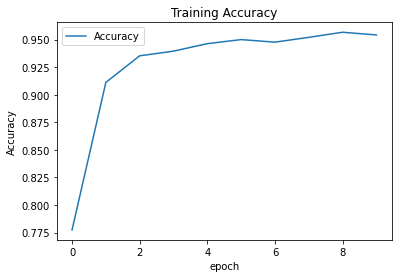

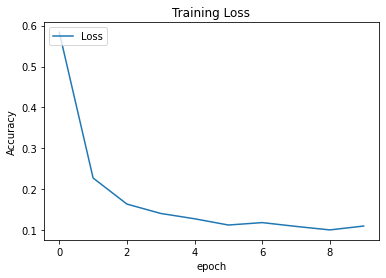

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_61 (ConvLSTM2D) (None, 1, 30, 64)         56320     
_________________________________________________________________
dropout_60 (Dropout)         (None, 1, 30, 64)         0         
_________________________________________________________________
flatten_60 (Flatten)         (None, 1920)              0         
_________________________________________________________________
dense_120 (Dense)            (None, 100)               192100    
_________________________________________________________________
dense_121 (Dense)            (None, 6)                 606       
Total params: 249,026
Trainable params: 249,026
Non-trainable params: 0
_________________________________________________________________
Confusion Matrix:
[[458   9  29   0   0   0]
 [  3 444  24   0   0   0]
 [  3   7 410   0   0   0]
 [  0  25   0 

In [44]:
import numpy
from numpy import mean
from numpy import std
from numpy import load
from numpy import dstack
from pandas import read_csv
import tensorflow.keras
from tensorflow.keras.utils import to_categorical
from google.colab import drive
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import ConvLSTM2D
import matplotlib.pyplot as plt
from matplotlib import style

# mount Google drive
drive.mount('/content/drive', force_remount=True)
projectDir = '/content/drive/MyDrive/Colab Notebooks/6505/UCI HAR Dataset/UCI HAR Dataset/train'

# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = '/content/drive/MyDrive/Colab Notebooks/6505/UCI HAR Dataset/UCI HAR Dataset/' + group + '/Inertial Signals/'
  
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y
 
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', '/content/drive/MyDrive/Colab Notebooks/6505/UCI HAR Dataset/UCI HAR Dataset/')
	print(trainX.shape, trainy.shape)
	# zero-offset class values
	trainy = trainy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	return trainX, trainy

def load_test_dataset(prefix=''):
  # load all test
	testX, testy = load_dataset_group('test', '/content/drive/MyDrive/Colab Notebooks/6505/UCI HAR Dataset/UCI HAR Dataset/')
	print(testX.shape, testy.shape)
	# zero-offset class values
	testy = testy - 1
	# one hot encode y
	testy = to_categorical(testy)
	return testX, testy

# load data
trainX, trainy = load_dataset()
testX, testy = load_test_dataset()

# define model parameters
verbose, epochs, batch_size = 1, 10, 64
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

# reshape into subsequences (samples, time steps, rows, cols, channels)
n_steps, n_length = 4, 32
trainX = trainX.reshape((trainX.shape[0], n_steps, 1, n_length, n_features))
testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))

# define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model fit
model_history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)

# model evaluate
scores = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print(model.metrics_names)
print(scores)

def plot_accuracy(history):
  plt.plot(history.history['accuracy'])
  plt.title('Training Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('epoch')
  plt.legend(['Accuracy'], loc='upper left')
  plt.show()
plot_accuracy(model_history)
plt.show()

def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.title('Training Loss')
  plt.ylabel('Accuracy')
  plt.xlabel('epoch')
  plt.legend(['Loss'], loc='upper left')
  plt.show()
plot_loss(model_history)
plt.show()

model.summary()

from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(testX)
matrix = confusion_matrix(testy.argmax(axis=1), predictions.argmax(axis=1))
print('Confusion Matrix:')
print(matrix)
print('Classification Report:')
print(classification_report(testy.argmax(axis=1), predictions.argmax(axis=1)))